<a href="https://colab.research.google.com/github/MartinaWestrik/Eurosat-Neural-Networks/blob/Vlastni-model_sjednocena_priprava_dat/DATA_proof_V0_z_V1_VGG16_Eurosat_s_augmentaci_4vrstvy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#INFO O PROJEKTU
**Cílem** projektu je vytrénování modelu, který na základě analýzy datasetu 27000 satelitních snímků ze zařízení Sentinel2 rozpoznává 10 druhů tříd land use - využití půdy, např. pole, pastvina, dálnice, jezera, řeky, zastavěné území, průmyslová zóna apod. Snímky mají po úpravě ze 13 spektrálního nastavení (EuroSATallBands, *tif) pouze tříbarvené kanály (RGB), rozměry 64x64 pixelů (EuroSAT, *.jpg) Projekt jsme si vybrali na https://www.kaggle.com/datasets/apollo2506/eurosat-dataset, k sestavování modelu jsme využili zdejší kody, chatgpt, vzorový příklad na Colab - šachy.

**Postup**

Postavení vlastního modelu neuronové sítě a ladění parametrů (V0)

Použití předtrénovaného modelu VGG16 (V1) a XXX (V2) pro efektivnější trénování.

Vyhodnocení modelů pomocí přesnosti a konfuzní matice.

#NAČTENÍ KNIHOVEN

In [ ]:
# Importy
import os
import random

import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt  # Vizualizace
import seaborn as sns  # Matice záměn
from sklearn.metrics import confusion_matrix, classification_report  # Klasifikační metriky

import kagglehub
from google.colab import files

#NAČTENÍ DAT

In [ ]:
# Download latest version
path = kagglehub.dataset_download("apollo2506/eurosat-dataset")

print("Path to dataset files:", path)

100%|██████████| 2.04G/2.04G [00:26<00:00, 84.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/apollo2506/eurosat-dataset/versions/6


In [ ]:
# 1. Nastavení správné cesty ke složce s obrázky
DATASET_PATH = "/root/.cache/kagglehub/datasets/apollo2506/eurosat-dataset/versions/6"
print("Dataset obsahuje:", os.listdir(DATASET_PATH))

Dataset obsahuje: ['EuroSAT', 'EuroSATallBands']


In [ ]:
# 2. Cesta ke složkám s obrázky
data_dir = os.path.join(DATASET_PATH, "EuroSAT")

# 3. Parametry datasetu
IMG_SIZE = (64, 64)
BATCH_SIZE = 32
NUM_CLASSES = 10

In [ ]:
# 4. Načtení datasetu a příprava dat pomocí ImageDataGenerator a augemtnací

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,         # mírná rotace – satelitní úhly se mohou lišit
    zoom_range=0.1,            # mírné přiblížení/oddálení
    horizontal_flip=True,      # satelitní záběry jsou symetrické – horizontální flip dává smysl
    fill_mode='nearest',
    validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    shuffle=True,             # lépe pro učení
    target_size=(128,128),    #ZVETSENI OBRAZKU Z GENERATORU
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)
val_generator = train_datagen.flow_from_directory(
    data_dir,
    shuffle=False,            # zachovat pro správné vyhodnocení
    target_size=(128,128),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


#VLASTNÍ MODEL

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

In [ ]:
# vytvoření  vlastního modelu, ; Sequentional= každá vrstva přidává novou transformaci dat, která zlepšuje schopnost modelu rozpoznávat vzory
model = Sequential([
    # první konvoluční vrstva
    Input(shape=(128,128, 3)),
    Conv2D(32, (3,3), activation='relu'),                         #32 filtrů hledá jiné vzory v matrici 3x3 pixely, "relu"převádí záporné hodnoty aktivační funkce na nulu, model očekává obrázky RGB 64x64
    MaxPooling2D(2,2),                                             # pooling snižuje velikost obrázků (na polovinu = 32x32) => snižuje rozsah výpočtu a vybírá ty nejdůležitější tvary na obrázku

    # druhá konvoluční vrstva
    Conv2D(64, (3,3), activation='relu'),                          #64 filtrů analyzuje složitější tvary,
    MaxPooling2D(2,2),                                              # snižuje velikost obrázku na 16x16

    # třetí konvoluční vrstva
    Conv2D(128, (3,3), activation='relu'), #nasazuje 128 filtrů     #stabilizuje výstupy z neuronů
    MaxPooling2D(2,2),                                               #snižuje velikost obrázku na 8x8

    # čtvrtá konvoluční vrstva
    Conv2D(128, (3,3), activation='relu'), #nasazuje 128 filtrů     #stabilizuje výstupy z neuronů
    MaxPooling2D(2,2),                                               #snižuje velikost obrázku na 8x8

    # zploštění převede data z 8x8x256 => máme vektor s 16 384 prvky, které mohou vstoupit do dense vrstvy se 256 neurony  a
    Flatten(),

    #DOPLNĚNÍ DENSE vrstvy pro VÍCE PARAMETRŮ TRÉNOVÁNÍ
    Dense(512, activation='relu'),
    Dropout(0.4),

    # .... do dense vsrtvy se 256 neurony a přirpavit se na klasifikaci
    Dense(256, activation='relu'),
    Dropout(0.3),                                                # v dense vrstvě "vypne" 30% neuronů, brání tím přeučení

    # výstupní vrstva s 10 třídami (softmax pro klasifikaci)
    Dense(10, activation='softmax')
])

In [ ]:
# 9. Kompilace modelu
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])
# 10. Výpis struktury modelu
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 12, 12, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,734,538 (10.43 MB)

 Trainable params: 2,734,538 (10.43 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 11. Definování EarlyStopping callbacku
early_stopping = EarlyStopping(
    monitor="val_loss",   # Sledujeme validační ztrátu
    patience=3,           # Po 3 epochách bez zlepšení ukončí trénování
    restore_best_weights=True # Vrátí nejlepší model
)

In [ ]:
# 12. Definování callbacku pro ukládání nejlepšího modelu
checkpoint = ModelCheckpoint(
    filepath="best_model.keras",  # Uložení modelu do souboru
    monitor="val_accuracy",       # Sleduje nejlepší přesnost na validačních datech
    save_best_only=True,          # Uloží pouze nejlepší model
    save_weights_only=False,      # Uloží model včetně architektury (ne jen váhy)
    verbose=1                     # Zobrazí info o ukládání
)

In [ ]:
# 13. Trénování modelu
EPOCHS = 100
history = model.fit(train_generator, epochs=EPOCHS, validation_data=val_generator,verbose=1, callbacks=[early_stopping, checkpoint])

Epoch 1/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2674 - loss: 1.8573
Epoch 1: val_accuracy improved from -inf to 0.57944, saving model to best_model.keras
675/675 ━━━━━━━━━━━━━━━━━━━━ 940s 1s/step - accuracy: 0.2676 - loss: 1.8569 - val_accuracy: 0.5794 - val_loss: 1.1596
Epoch 2/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5405 - loss: 1.2062
Epoch 2: val_accuracy improved from 0.57944 to 0.68148, saving model to best_model.keras
675/675 ━━━━━━━━━━━━━━━━━━━━ 971s 1s/step - accuracy: 0.5405 - loss: 1.2061 - val_accuracy: 0.6815 - val_loss: 0.8743
Epoch 3/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6474 - loss: 0.9824
Epoch 3: val_accuracy improved from 0.68148 to 0.72333, saving model to best_model.keras
675/675 ━━━━━━━━━━━━━━━━━━━━ 923s 1s/step - accuracy: 0.6474 - loss: 0.9823 - val_accuracy: 0.7233 - val_loss: 0.7717
Epoch 4/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7001 - loss: 0.8331
Epoch 4: val_accuracy improved from 0.

In [ ]:
# 14. Vyhodnocení modelu na validační sadě
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validační přesnost: {val_acc:.4f}")

169/169 ━━━━━━━━━━━━━━━━━━━━ 70s 411ms/step - accuracy: 0.8457 - loss: 0.4412
Validační přesnost: 0.8470


In [ ]:
# 15. Funkce pro predikci TOP-2 tříd u nového obrázku
def predict_top_2(image_path, model, class_indices):
    from tensorflow.keras.preprocessing import image

    img = image.load_img(image_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    predictions = model.predict(img_array)[0]

    top_2_indices = np.argsort(predictions)[-2:][::-1]
    top_2_classes = [list(class_indices.keys())[list(class_indices.values()).index(i)] for i in top_2_indices]
    top_2_probs = [predictions[i] for i in top_2_indices]

    return list(zip(top_2_classes, top_2_probs))

In [ ]:
# 16. Získání jmen tříd
class_indices = train_generator.class_indices

In [ ]:
# 17. Test predikce na náhodném obrázku z datasetu
random_image = random.choice(train_generator.filepaths)

top_2_predictions = predict_top_2(random_image, model, class_indices)
print(f"Top-2 predikované třídy pro obrázek: {top_2_predictions}")

ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_6" is incompatible with the layer: expected axis -1 of input shape to have value 4608, but received input with shape (1, 512)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(1, 64, 64, 3), dtype=float32)
  • training=False
  • mask=None

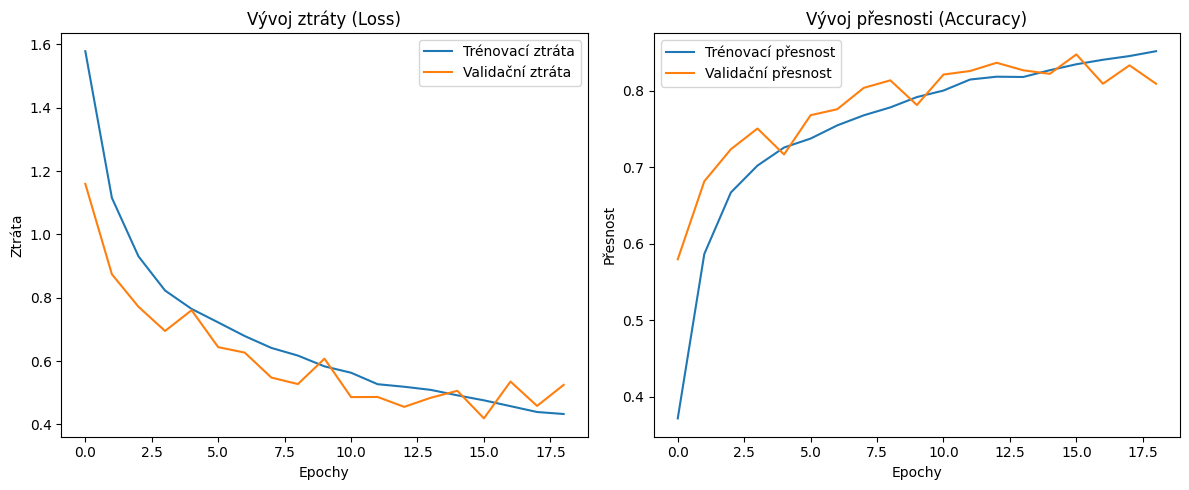

In [ ]:
# 18. Vizualizace trénování – Graf přesnosti a ztráty
def plot_training_history(history):
    import matplotlib.pyplot as plt  # pro jistotu, pokud není už importováno
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Graf ztráty (Loss)
    axs[0].plot(history.history['loss'], label='Trénovací ztráta')
    axs[0].plot(history.history['val_loss'], label='Validační ztráta')
    axs[0].set_title('Vývoj ztráty (Loss)')
    axs[0].set_xlabel('Epochy')
    axs[0].set_ylabel('Ztráta')
    axs[0].legend()

    # Graf přesnosti (Accuracy)
    axs[1].plot(history.history['accuracy'], label='Trénovací přesnost')
    axs[1].plot(history.history['val_accuracy'], label='Validační přesnost')
    axs[1].set_title('Vývoj přesnosti (Accuracy)')
    axs[1].set_xlabel('Epochy')
    axs[1].set_ylabel('Přesnost')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

# ✅ Teď zavoláš funkci mimo její tělo:
plot_training_history(history)

169/169 ━━━━━━━━━━━━━━━━━━━━ 71s 416ms/step


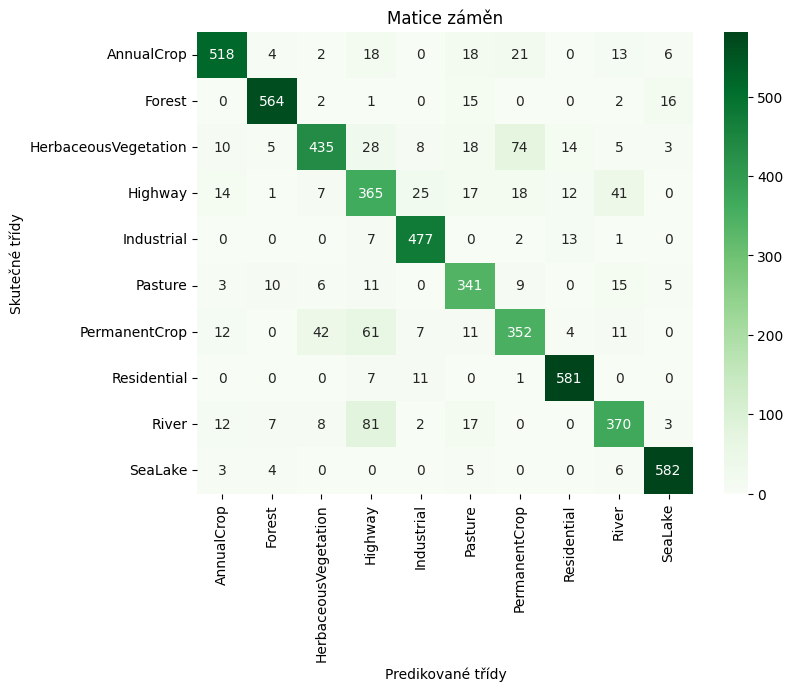


Klasifikační report:
                      precision    recall  f1-score   support

          AnnualCrop       0.91      0.86      0.88       600
              Forest       0.95      0.94      0.94       600
HerbaceousVegetation       0.87      0.72      0.79       600
             Highway       0.63      0.73      0.68       500
          Industrial       0.90      0.95      0.93       500
             Pasture       0.77      0.85      0.81       400
       PermanentCrop       0.74      0.70      0.72       500
         Residential       0.93      0.97      0.95       600
               River       0.80      0.74      0.77       500
             SeaLake       0.95      0.97      0.96       600

            accuracy                           0.85      5400
           macro avg       0.84      0.84      0.84      5400
        weighted avg       0.85      0.85      0.85      5400



In [ ]:
# Získání skutečných a predikovaných hodnot
y_true = val_generator.classes  # Skutečné třídy
y_pred_probs = model.predict(val_generator)  # Predikované pravděpodobnosti
y_pred = y_pred_probs.argmax(axis=1)  # Nejpravděpodobnější třídy

# Matice záměn
cm = confusion_matrix(y_true, y_pred)
labels = list(val_generator.class_indices.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predikované třídy")
plt.ylabel("Skutečné třídy")
plt.title("Matice záměn")
plt.show()

# Výpis klasifikační zprávy
print("\nKlasifikační report:")
print(classification_report(y_true, y_pred, target_names=labels))

#Vizualizace záměn


In [ ]:
# Získáme nejčastější chybnou záměnu (ignorujeme diagonálu = správné predikce)
cm_copy = cm.copy()
np.fill_diagonal(cm_copy, 0)  # odstraníme správné klasifikace
max_confusion = np.unravel_index(np.argmax(cm_copy), cm_copy.shape)

true_class_idx, pred_class_idx = max_confusion
true_class = labels[true_class_idx]
pred_class = labels[pred_class_idx]

print(f"🔍 Nejčastější záměna: Skutečná třída = '{true_class}', Predikovaná = '{pred_class}'")

🔍 Nejčastější záměna: Skutečná třída = 'River', Predikovaná = 'Highway'


In [ ]:
 #Převedeme generator do DataFrame (pokud máš flow_from_dataframe, použij přímo val_df)
 import pandas as pd
val_filenames = val_generator.filenames  # cesty k obrázkům
df_val = pd.DataFrame({
    "filename": val_filenames,
    "true_label": y_true,
    "pred_label": y_pred
})

# Vybereme příklady, kde došlo ke konkrétní záměně
mistakes = df_val[(df_val["true_label"] == true_class_idx) & (df_val["pred_label"] == pred_class_idx)]

<ipython-input-36-80aa9fc4b5fc>:17: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


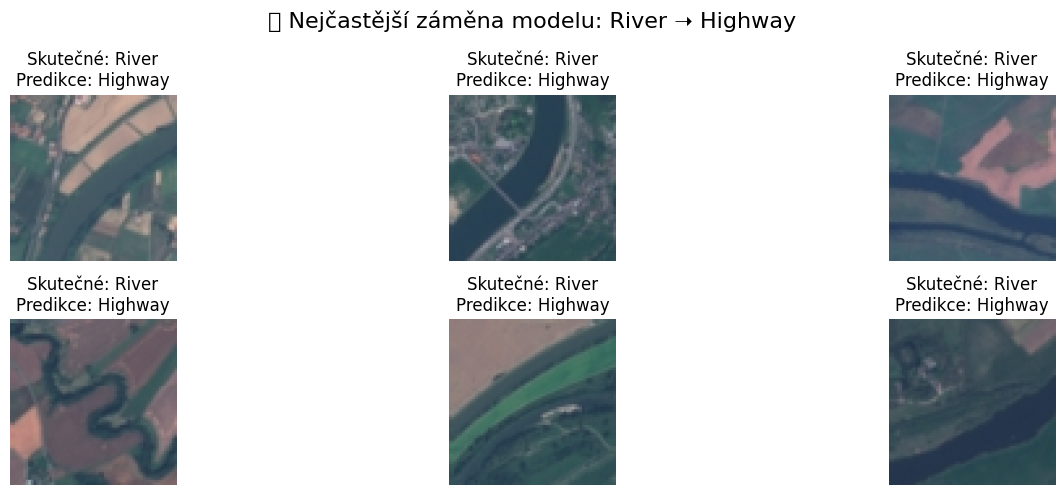

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Zobrazíme max 5 chybných obrázků
sample_mistakes = mistakes.sample(n=min(6, len(mistakes)))

plt.figure(figsize=(15, 5))
for i, row in enumerate(sample_mistakes.itertuples()):
    img_path = os.path.join(val_generator.directory, row.filename)
    img = load_img(img_path, target_size=(128, 128))  # přizpůsob target_size

    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Skutečné: {true_class}\nPredikce: {pred_class}")

plt.suptitle(f"🔍 Nejčastější záměna modelu: {true_class} ➝ {pred_class}", fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
# Stáhnutí modelu do počítače
files.download("best_model.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>